# Quantitiative Methods Reproducible Analysis for Assessment 3
Student ID: 21197822

References for code are linked for come from class practicals.

In [1]:
#load packages

import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import sklearn
import matplotlib.pyplot as plt

## Loading and Cleaning Data

### Personal Wellbeing

In [2]:
# Load data
# https://data.london.gov.uk/dataset/subjective-personal-well-being-borough
wellb0 = pd.read_excel(
    'https://data.london.gov.uk/download/subjective-personal-well-being-borough/d1bae8e8-f07b-4c2f-aec7-deed8006b52a/personal-well-being-borough.xlsx', 
    sheet_name='Summary - Mean Scores',
    header=[0,1])            # Where are the column names... there's three of them!

In [3]:
# Clean data
wellb = wellb0[[(' ', 'Code'), 
               (' ', 'Area'),
               ('Life Satisfaction', '2018/19'),
               ('Worthwhile', '2018/19'),
               ('Happiness', '2018/19'),
               ('Anxiety', '2018/19')]]
wellb = wellb.droplevel(1, axis=1)
wellb.columns = ['Code', 'Area', 'Life Satisfaction', 'Worthwhile', 'Happiness', 'Anxiety']
wellb.dropna(inplace = True)
wellb = wellb.iloc[:32]
wellb['Happiness'] = pd.to_numeric(wellb['Happiness'])
wellb['Anxiety'] = pd.to_numeric(wellb['Anxiety'])

### GreenBlue

In [4]:
# Load data
# https://data.london.gov.uk/dataset/green-and-blue-cover
greenblue0 = pd.read_excel(
    'https://data.london.gov.uk/download/green-and-blue-cover/7056efeb-d34a-4394-9d62-2f335edeacec/green_cover_ward_summary_0.05.xlsx',
    sheet_name='ward_green_cover')

In [5]:
# Clean data
greenblue = greenblue0[['lb_name', 'lb_code', 'ward_code', 'ward_name',
       'percent_green', 'percent_blue', 'percent_green+blue']]
#greenblue['percent_blue'] = np.log10(greenblue['percent_blue'])
#greenblue['percent_blue'].replace([np.inf, -np.inf], np.nan, inplace=True)
greenblue.dropna(inplace=True)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### Load Access data

In [6]:
# Load data
# https://data.london.gov.uk/dataset/access-public-open-space-and-nature-ward
access_h0 = pd.read_excel(
    'https://data.london.gov.uk/download/access-public-open-space-and-nature-ward/18fc0bef-68af-42c1-b77c-d6babbb66465/access-public-open-space-ward.xls',
    sheet_name='Access to open space 2013 wards',
    header=[0,1])

In [7]:
#Clean data

# Units: Percentage of households with access to: each type of park
access_h= access_h0.droplevel(0, axis=1)
access_h = access_h.iloc[:625]

In [8]:
# https://data.london.gov.uk/dataset/access-public-open-space-and-nature-ward
access_o0 = pd.read_excel(
    'https://data.london.gov.uk/download/access-public-open-space-and-nature-ward/18fc0bef-68af-42c1-b77c-d6babbb66465/access-public-open-space-ward.xls',
    sheet_name='Open space 2013 wards',
    header=[0])

In [9]:
access_o = access_o0[['Ward_GSS_CODE','Ward_NAME','BOROUGH_LB_GSS_CD','BOROUGH_Name',
                      '% of open space that has access']]
access_o = access_o.iloc[:624]
access_o.tail()
# no city of London, 'Ward_GSS_CODE'=='E09000001'

,Ward_GSS_CODE,Ward_NAME,BOROUGH_LB_GSS_CD,BOROUGH_Name,% of open space that has access
619,E05000645,Tachbrook,E09000033,Westminster,64.713326
620,E05000646,Vincent Square,E09000033,Westminster,58.893270
621,E05000647,Warwick,E09000033,Westminster,20.429739
622,E05000648,Westbourne,E09000033,Westminster,41.628560
623,E05000649,West End,E09000033,Westminster,38.690776


## Merging Data

In [10]:
#Checking data before merging

#Greater London is composed of London boroughs, the 32 local authority districts
#City of London has 25 wards
print(access_h.shape)
print(access_o.shape)
print(greenblue.shape)
print(wellb.shape)
#print(atlas.shape)
print('')
print(access_h['Borough name'].unique().shape)
print(access_o['BOROUGH_Name'].unique().shape)
print(greenblue['lb_name'].unique().shape)
print(wellb['Area'].unique().shape)
print('')
print(access_h['Ward name'].unique().shape)
print(access_o['Ward_GSS_CODE'].unique().shape)
print(greenblue['ward_name'].unique().shape)

(625, 8)
(624, 5)
(657, 7)
(32, 6)

(33,)
(32,)
(33,)
(32,)

(604,)
(624,)
(638,)


In [11]:
#Merging

df = pd.merge(access_h, access_o, left_on='WD13CD', right_on='Ward_GSS_CODE', how='inner')
print(df.shape)

#df = pd.merge(df, greenblue, left_on='WD13CD', right_on='ward_code', how='inner')
df = pd.merge(df, greenblue, left_on='Ward_NAME', right_on='ward_name', how='inner')
print(df.shape)

df = pd.merge(df, wellb, left_on='lb_code', right_on='Code', how='left')
print(df.shape)

df = df[['WD13CD', 'Ward name', 'Borough name', 
         
         # Mean per ward = borough mean * (pop ratio of ward /borough)
         'Life Satisfaction', 'Worthwhile', 'Happiness', 'Anxiety',
         
         # Percentage of households in ward with access to
         'Open Space', 'Local Parks', 'District Parks', 'Metropolitan Parks', 'Regional Parks',
         
         # Per ward
         '% of open space that has access',
         
         # Coverage per ward
         'percent_green', 'percent_blue', 'percent_green+blue']]
             
print(df.shape)

#df.isnull().sum(axis=0).sort_values(ascending=False)
df.dropna(inplace=True)
#df.dtypes
#df.isnull().sum(axis=0).sort_values(ascending=False)

(624, 13)
(600, 20)
(600, 26)
(600, 16)


In [12]:
# Some subsets for manipulation

dfplot = df.drop(columns=['WD13CD', 'Ward name', 'Borough name'])

df0 = df[['Life Satisfaction', 'Worthwhile', 'Happiness', 'Anxiety']]

df1 = df[['Open Space', 'Local Parks', 'District Parks', 'Metropolitan Parks', 'Regional Parks',
                     '% of open space that has access']]

df2 = df[['percent_green', 'percent_blue', 'percent_green+blue']]

## Plotting Distributions

/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt

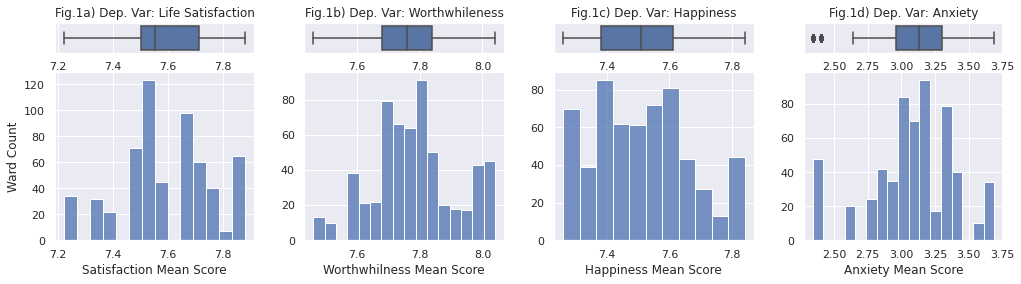

In [13]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(17, 4))
gs = fig.add_gridspec(1, 4, wspace=0.25, hspace=0)

gssub0 = gs[0].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax0h = fig.add_subplot(gssub0[1])
ax0b = fig.add_subplot(gssub0[0], sharex = ax0h)

gssub1 = gs[1].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax1h = fig.add_subplot(gssub1[1])
ax1b = fig.add_subplot(gssub1[0], sharex = ax1h)

gssub2 = gs[2].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax2h = fig.add_subplot(gssub2[1])
ax2b = fig.add_subplot(gssub2[0], sharex = ax2h)

gssub3 = gs[3].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax3h = fig.add_subplot(gssub3[1])
ax3b = fig.add_subplot(gssub3[0], sharex = ax3h)

sns.boxplot(df['Life Satisfaction'], ax=ax0b)
sns.boxplot(df['Worthwhile'], ax=ax1b)
sns.boxplot(df['Happiness'], ax=ax2b)
sns.boxplot(df['Anxiety'], ax=ax3b)

sns.histplot(data=df, x="Life Satisfaction", ax=ax0h)
sns.histplot(data=df, x='Worthwhile', ax=ax1h)
sns.histplot(data=df, x='Happiness', ax=ax2h)
sns.histplot(data=df, x='Anxiety', ax=ax3h)

ax0b.set(xlabel='', title='Fig.1a) Dep. Var: Life Satisfaction')
ax1b.set(xlabel='', title='Fig.1b) Dep. Var: Worthwhileness')
ax2b.set(xlabel='', title='Fig.1c) Dep. Var: Happiness')
ax3b.set(xlabel='', title='Fig.1d) Dep. Var: Anxiety')

ax0h.set(ylabel='Ward Count')
ax1h.set(ylabel='')
ax2h.set(ylabel='')
ax3h.set(ylabel='')

ax0h.set(xlabel='Satisfaction Mean Score')
ax1h.set(xlabel='Worthwhilness Mean Score')
ax2h.set(xlabel='Happiness Mean Score')
ax3h.set(xlabel='Anxiety Mean Score')

plt.show()

#https://www.python-graph-gallery.com/24-histogram-with-a-boxplot-on-top-seaborn
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.gridspec.GridSpecFromSubplotSpec.html#matplotlib.gridspec.GridSpecFromSubplotSpec

/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


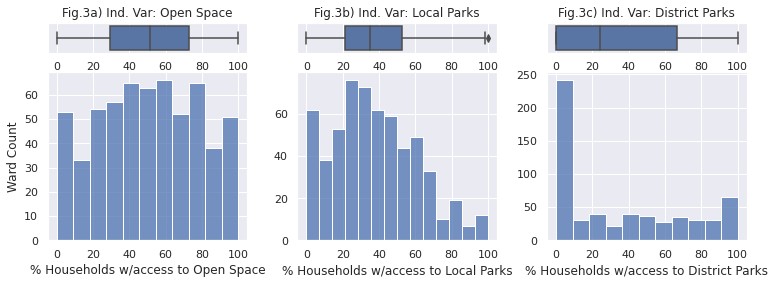

In [14]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(17, 4))
gs = fig.add_gridspec(1, 4, wspace=0.25, hspace=0)

gssub0 = gs[0].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax0h = fig.add_subplot(gssub0[1])
ax0b = fig.add_subplot(gssub0[0], sharex = ax0h)

gssub1 = gs[1].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax1h = fig.add_subplot(gssub1[1])
ax1b = fig.add_subplot(gssub1[0], sharex = ax1h)

gssub2 = gs[2].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax2h = fig.add_subplot(gssub2[1])
ax2b = fig.add_subplot(gssub2[0], sharex = ax2h)

sns.boxplot(df['Open Space'], ax=ax0b)
sns.boxplot(df['Local Parks'], ax=ax1b)
sns.boxplot(df['District Parks'], ax=ax2b)

sns.histplot(data=df, x="Open Space", ax=ax0h)
sns.histplot(data=df, x='Local Parks', ax=ax1h)
sns.histplot(data=df, x='District Parks', ax=ax2h)

ax0b.set(xlabel='', title='Fig.3a) Ind. Var: Open Space')
ax1b.set(xlabel='', title='Fig.3b) Ind. Var: Local Parks')
ax2b.set(xlabel='', title='Fig.3c) Ind. Var: District Parks')

ax0h.set(ylabel='Ward Count')
ax1h.set(ylabel='')
ax2h.set(ylabel='')

ax0h.set(xlabel='% Households w/access to Open Space')
ax1h.set(xlabel='% Households w/access to Local Parks')
ax2h.set(xlabel='% Households w/access to District Parks')

plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


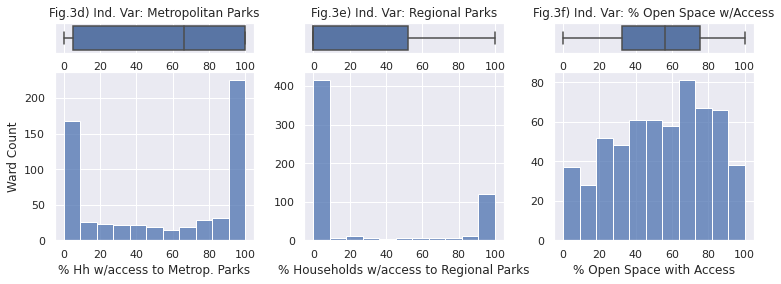

In [15]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(17, 4))
gs = fig.add_gridspec(1, 4, wspace=0.25, hspace=0)

gssub0 = gs[0].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax0h = fig.add_subplot(gssub0[1])
ax0b = fig.add_subplot(gssub0[0], sharex = ax0h)

gssub1 = gs[1].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax1h = fig.add_subplot(gssub1[1])
ax1b = fig.add_subplot(gssub1[0], sharex = ax1h)

gssub2 = gs[2].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax2h = fig.add_subplot(gssub2[1])
ax2b = fig.add_subplot(gssub2[0], sharex = ax2h)

sns.boxplot(df['Metropolitan Parks'], ax=ax0b)
sns.boxplot(df['Regional Parks'], ax=ax1b)
sns.boxplot(df['% of open space that has access'], ax=ax2b)

sns.histplot(data=df, x="Metropolitan Parks", ax=ax0h)
sns.histplot(data=df, x='Regional Parks', ax=ax1h)
sns.histplot(data=df, x='% of open space that has access', ax=ax2h)

ax0b.set(xlabel='', title='Fig.3d) Ind. Var: Metropolitan Parks')
ax1b.set(xlabel='', title='Fig.3e) Ind. Var: Regional Parks')
ax2b.set(xlabel='', title='Fig.3f) Ind. Var: % Open Space w/Access')

ax0h.set(ylabel='Ward Count')
ax1h.set(ylabel='')
ax2h.set(ylabel='')

ax0h.set(xlabel='% Hh w/access to Metrop. Parks')
ax1h.set(xlabel='% Households w/access to Regional Parks')
ax2h.set(xlabel='% Open Space with Access')

plt.show()

/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/sds2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


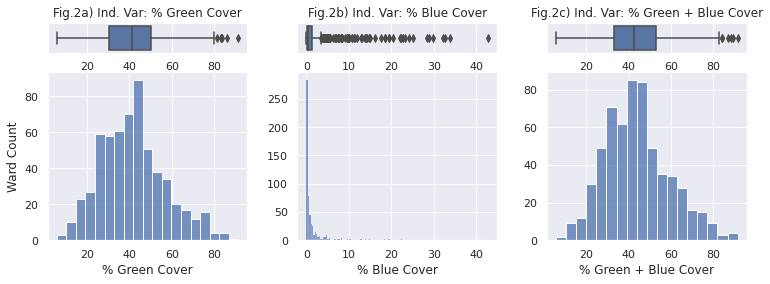

In [17]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(17, 4))
gs = fig.add_gridspec(1, 4, wspace=0.25, hspace=0)

gssub0 = gs[0].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax0h = fig.add_subplot(gssub0[1])
ax0b = fig.add_subplot(gssub0[0], sharex = ax0h)

gssub1 = gs[1].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax1h = fig.add_subplot(gssub1[1])
ax1b = fig.add_subplot(gssub1[0], sharex = ax1h)

gssub2 = gs[2].subgridspec(2, 1, height_ratios=(.15, .85)) 
ax2h = fig.add_subplot(gssub2[1])
ax2b = fig.add_subplot(gssub2[0], sharex = ax2h)

sns.boxplot(df['percent_green'], ax=ax0b)
sns.boxplot(df['percent_blue'], ax=ax1b)
sns.boxplot(df['percent_green+blue'], ax=ax2b)

sns.histplot(data=df, x="percent_green", ax=ax0h)
sns.histplot(data=df, x='percent_blue', ax=ax1h)
sns.histplot(data=df, x='percent_green+blue', ax=ax2h)

ax0b.set(xlabel='', title='Fig.2a) Ind. Var: % Green Cover')
ax1b.set(xlabel='', title='Fig.2b) Ind. Var: % Blue Cover')
ax2b.set(xlabel='', title='Fig.2c) Ind. Var: % Green + Blue Cover')

ax0h.set(ylabel='Ward Count')
ax1h.set(ylabel='')
ax2h.set(ylabel='')

ax0h.set(xlabel='% Green Cover')
ax1h.set(xlabel='% Blue Cover')
ax2h.set(xlabel='% Green + Blue Cover')

plt.show()

In [18]:
df1 = df[['Open Space', 'Local Parks', 'District Parks', 'Metropolitan Parks', 'Regional Parks',
                     '% of open space that has access']]

df2 = df[['percent_green', 'percent_blue', 'percent_green+blue']]

## Multicollinearity
(Multi)Collinearity occurs when two (or more) variables are highly correlated.
- Visualising correlation with correlation matrices.
- Detecting collinearity with Variance Inflation Factor (VIF)

In [19]:
# Correlation Matrix

# Input data must be in columns of numbers without column labels, saved in a csv.
# Each column is a data series, X0, X1, X2, etc.
# resaving replaces existing file
dfplot.to_csv('prematrix.csv', header=False, index=False)

# read csv
prematrix = np.genfromtxt('prematrix.csv',delimiter = ',')

# generate correlation matrix
correlation_matrix = np.corrcoef(prematrix.T)

# correlation_matrix[i,j] is the correlation between the series Xi and Xj.
print(correlation_matrix)

[[ 1.00000000e+00  7.23777778e-01  7.21242159e-01 -4.44448988e-01
  -2.53507995e-01 -1.32300420e-01 -7.48327955e-02 -2.20056592e-02
  -1.07233788e-02 -6.00623501e-02  1.34597597e-01 -1.81623605e-02
   1.29075122e-01]
 [ 7.23777778e-01  1.00000000e+00  6.58924470e-01 -3.32769964e-01
  -2.26768295e-01 -8.00195359e-02 -7.09048871e-02 -1.75645108e-02
   2.10798266e-02 -2.71056307e-02  1.26152491e-01 -3.83093794e-03
   1.25416808e-01]
 [ 7.21242159e-01  6.58924470e-01  1.00000000e+00 -5.51328914e-01
  -3.77233459e-01 -3.78044636e-02 -4.81770710e-02 -5.27121747e-02
  -1.26286532e-01 -4.40824942e-02  5.10752536e-02 -3.79659853e-02
   3.85203567e-02]
 [-4.44448988e-01 -3.32769964e-01 -5.51328914e-01  1.00000000e+00
   9.74867427e-02  2.54588739e-01  4.22078918e-02  2.28023286e-01
  -4.74159438e-03  4.29080367e-02 -2.08190565e-01  5.97077012e-02
  -1.89007254e-01]
 [-2.53507995e-01 -2.26768295e-01 -3.77233459e-01  9.74867427e-02
   1.00000000e+00 -2.82741946e-04 -2.09948885e-02 -3.42216494e-02


In [ ]:
# Correlation Matrix Visualisation

plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(15, 13))

plt.matshow(dfplot.corr(), fignum=f.number)
plt.xticks(range(dfplot.shape[1]), dfplot.columns, fontsize=14, rotation=80)
plt.yticks(range(dfplot.shape[1]), dfplot.columns, fontsize=14)
plt.title('Fig.4) Correlation Matrix', fontsize=16)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

f.savefig(os.path.join('corr_matrix'), dpi=200)

I predict ... to be collinear

In [ ]:
# calculating VIF to drop collinear variables
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [ ]:
noncoll = drop_column_using_vif_(
    dfplot.drop('Life Satisfaction',axis=1)
            .drop('Worthwhile',axis=1)
            .drop('Happiness',axis=1)
            .drop('Anxiety',axis=1)
#            .drop('Open Space',axis=1)
)

## Multiple Regression

In [ ]:
import statsmodels.api as sm

In [ ]:
satis = sm.OLS(endog = dfplot[['Life Satisfaction']], 
              exog = sm.add_constant(noncoll)).fit()
worth = sm.OLS(endog = dfplot[['Worthwhile']], 
              exog = sm.add_constant(noncoll)).fit()
happy = sm.OLS(endog = dfplot[['Happiness']], 
              exog = sm.add_constant(noncoll)).fit()
anxi = sm.OLS(endog = dfplot[['Anxiety']], 
              exog = sm.add_constant(noncoll)).fit()

#satis.summary()
worth.summary()
#happy.summary()
#anxi.summary()

In [ ]:
# Visualise Residuals 

fig1, ax = plt.subplots()#figsize=(8,6))
ax.scatter(x=satis.fittedvalues , y=satis.resid)
ax.axhline(y=0, color = 'black', linestyle='-')
plt.title('Fig.5a) Life Satisfaction: Residuals vs. Fits')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

fig2 = plt.hist(satis.resid)
plt.title('Fig.5b) Life Satisfaction: Residuals')
plt.xlabel('Residuals')
plt.ylabel('Counts')
plt.show()



fig3, ax = plt.subplots()#figsize=(8,6))
ax.scatter(x=worth.fittedvalues , y=worth.resid)
ax.axhline(y=0, color = 'black', linestyle='-')
plt.title('Fig.6a) Worthwhile: Residuals vs. Fits')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

fig4 = plt.hist(worth.resid)
plt.title('Fig.6b) Worthwhile: Residuals')
plt.xlabel('Residuals')
plt.ylabel('Counts')
plt.show()



fig5, ax = plt.subplots()#figsize=(8,6))
ax.scatter(x=happy.fittedvalues , y=happy.resid)
ax.axhline(y=0, color = 'black', linestyle='-')
plt.title('Fig.7a) Happiness: Residuals vs. Fits')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

fig6 = plt.hist(happy.resid)
plt.title('Fig.7b) Happiness: Residuals')
plt.xlabel('Residuals')
plt.ylabel('Counts')
plt.show()


fig7, ax = plt.subplots()#figsize=(8,6))
ax.scatter(x=anxi.fittedvalues , y=anxi.resid)
ax.axhline(y=0, color = 'black', linestyle='-')
plt.title('Fig.8a) Anxiety: Residuals vs. Fits')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

fig8 = plt.hist(anxi.resid)
plt.title('Fig.8b) Anxiety: Residuals')
plt.xlabel('Residuals')
plt.ylabel('Counts')
plt.show()